In [110]:
'''
@author: nathanvaughn
'''
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.special import erf
from scipy.special import sph_harm
import os
import upf_to_json

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt


In [208]:
class Atom(object):
    '''
    The gridpoint object.  Will contain the coordinates, wavefunction value, and any other metadata such as
    whether or not the wavefunction has been updated, which cells the gridpoint belongs to, etc.
    '''
    def __init__(self, x,y,z,atomicNumber,nAtomicOrbitals):
        '''
        Atom Constructor
        '''
        self.x = x
        self.y = y
        self.z = z
        self.atomicNumber = int(atomicNumber)
        self.orbitalInterpolators()
        self.nAtomicOrbitals = nAtomicOrbitals
        
    def setPseudopotentialObject(self, PSPs,verbose=0):
        ## If the pseudopotential dictionary already contains this atomic number, have it point there.
        ## Otherwise, need to create a new one.
        print("Setting PSP for atomic number ", self.atomicNumber)
        try: 
            self.PSP = PSPs[str(self.atomicNumber)]
            if verbose>0: print("PSP already present for atomic number ", self.atomicNumber)
        except KeyError:
            if verbose>0: print("PSP not already present for atomic number ", self.atomicNumber)
            PSPs[str(self.atomicNumber)] = ONCV_PSP(self.atomicNumber)
            if verbose>0: print("Updated PSPs: ",PSPs)
            self.PSP = PSPs[str(self.atomicNumber)]
        
    def V_all_electron(self,x,y,z):
        r = np.sqrt((x - self.x)**2 + (y-self.y)**2 + (z-self.z)**2)
        return -self.atomicNumber/r
    
    def V_local_pseudopotential(self,x,y,z):
        r = np.sqrt((x - self.x)**2 + (y-self.y)**2 + (z-self.z)**2)
        return self.PSP.evaluateLocalPotentialInterpolator(r)
    
    def V_nonlocal_pseudopotential_times_psi(self,x,y,z,psi,W,comm):
        
        output = np.zeros(np.len(psi))     
        ## sum over the projectors, increment the nonloncal potential. 
        for i in range(self.numberOfChis):
            C = global_dot( psi, self.Chi[i]*W, comm)
            output += C*self.Chi[i]
        return output
    
    def generateChi(self,x,y,z):
        self.Chi = {}
        D_ion_array = np.array(self.PSP['D_ion'][::self.PSP['header']['number_of_proj']+1]) # grab diagonals of matrix
        num_ell = int(self.PSP['header']['number_of_proj']/2)  # 2 projectors per ell for ONCV
        ID=0
        for ell in range(num_ell):
            for p in [0,1]:  # two projectors per ell for ONCV
                D_ion = D_ion_array[ID]
                for m in range(-ell,ell+1):

                    dx = X-atom.x
                    dy = Y-atom.y
                    dz = Z-atom.z
                    chi = np.zeros(len(dx))
                    r = np.sqrt( dx**2 + dy**2 + dz**2 )
                    inclination = np.arccos(dz/r)
                    azimuthal = np.arctan2(dy,dx)

                    if m<0:
                        Ysp = (sph_harm(m,ell,azimuthal,inclination) + (-1)**m * sph_harm(-m,ell,azimuthal,inclination))/np.sqrt(2) 
                    if m>0:
                        Ysp = 1j*(sph_harm(m,ell,azimuthal,inclination) - (-1)**m * sph_harm(-m,ell,azimuthal,inclination))/np.sqrt(2)

                    if ( m==0 ):
                        Ysp = sph_harm(m,ell,azimuthal,inclination)

                    if np.max( abs(np.imag(Ysp)) ) > 1e-14:
                        print('imag(Y) ', np.imag(Ysp))
                        return

                    chi = atom.PSP.evaluateProjectorInterpolators[str(2*ell+p)](r)*np.real(Ysp)
#                     ID = "ell_p_m__" + str(ell) + "_" + str(p) + "_" + str(m)
                    self.Chi[str(ID)] = chi*np.sqrt( D_ion )  # check np.sqrt( D_ion )
                    ID+=1
        self.numberOfChis = ID  # this is larger than number of projectors, which don't depend on m
                    
    def V_pseudopotential_times_psi(self,x,y,z,psi,W,comm):
        ## Call the local and nonlocal pseudopotential calculations.
        return self.V_local_pseudopotential(x,y,z)*psi + self.V_nonlocal_pseudopotential_times_psi(x,y,z,psi,W,comm)
        
    def setNumberOfOrbitalsToInitialize(self,verbose=0):
        if self.atomicNumber <=2:       
            self.nAtomicOrbitals = 1    # 1S 
        elif self.atomicNumber <=4:     
            self.nAtomicOrbitals = 2    # 1S 2S 
        elif self.atomicNumber <=10:    
            self.nAtomicOrbitals = 5    # 1S 2S 2P
        elif self.atomicNumber <=12:
            self.nAtomicOrbitals = 6    # 1S 2S 2P 3S 
        elif self.atomicNumber <=18:
            self.nAtomicOrbitals = 9    # 1S 2S 2P 3S 3P
        elif self.atomicNumber <=20:
            self.nAtomicOrbitals = 10   # 1S 2S 2P 3S 3P 4S
        elif self.atomicNumber <=30:
            self.nAtomicOrbitals = 15   # 1S 2S 2P 3S 3P 4S 3D
        else:
            print('Not ready for > 30 atomic number.  Revisit atom.setNumberOfOrbitalsToInitialize()')
        
        if verbose>0: print('Atom with Z=%i will get %i atomic orbitals initialized.' %(self.atomicNumber, self.nAtomicOrbitals))
        
        
    def orbitalInterpolators(self,verbose=0):
        
#         print("Setting up interpolators.")
        self.interpolators = {}
        # search for single atom data, either on local machine or on flux
        if os.path.isdir('/Users/nathanvaughn/AtomicData/allElectron/z'+str(int(self.atomicNumber))+'/singleAtomData/'):
            # working on local machine
            path = '/Users/nathanvaughn/AtomicData/allElectron/z'+str(int(self.atomicNumber))+'/singleAtomData/'
        elif os.path.isdir('/home/njvaughn/AtomicData/allElectron/z'+str(int(self.atomicNumber))+'/singleAtomData/'):
            # working on Flux or Great Lakes
            path = '/home/njvaughn/AtomicData/allElectron/z'+str(int(self.atomicNumber))+'/singleAtomData/'
        else:
            print('Could not find single atom data...')
            print('Checked in: /Users/nathanvaughn/AtomicData/allElectron/z'+str(int(self.atomicNumber))+'/singleAtomData/')
            print('Checked in: /home/njvaughn/AtomicData/allElectron/z'+str(int(self.atomicNumber))+'/singleAtomData/')
            
            
        if verbose>0: print('Using single atom data from:')
        if verbose>0: print(path)
        for singleAtomData in os.listdir(path): 
            if singleAtomData[:3]=='psi':
                data = np.genfromtxt(path+singleAtomData)
                self.interpolators[singleAtomData[:5]] = InterpolatedUnivariateSpline(data[:,0],data[:,1],k=3,ext=0)
            elif singleAtomData[:7]=='density':
                data = np.genfromtxt(path+singleAtomData)
                self.interpolators[singleAtomData[:7]] = InterpolatedUnivariateSpline(data[:,0],data[:,1],k=3,ext=0)        


In [244]:
class ONCV_PSP(object):
    '''
    The ONCV Pseudopotential object.  Will contain the interpolators needed for the nonlocal potential,
    the density initialization, etc.
    '''
    def __init__(self,atomicNumber):
        '''
        PSP Constructor
        '''
        self.atomicNumber=atomicNumber
        pspFile = "/Users/nathanvaughn/Desktop/ONCV_PSPs_Z/"+str(atomicNumber)+"_ONCV_PBE-1.0.upf"
        upf_str = open(pspFile, 'r').read()
        psp_temp = upf_to_json.upf_to_json(upf_str, pspFile)
        self.psp = psp_temp['pseudo_potential']
        self.setProjectorInterpolators()
        self.setDensityInterpolator()
        self.setLocalPotentialInterpolator()
        
    def setDensityInterpolator(self,verbose=0):
        r = np.array(self.psp['radial_grid'])
        self.maxRadialGrid = r[-1]
        density = np.array(self.psp['total_charge_density'])
        ## Is it okay to set the boundary condition to zero?  
        self.densityInterpolator = InterpolatedUnivariateSpline(r[1:],density[1:],k=3,ext='raise')
        
        # Setup decaying exponential for extrapolation beyond rcutoff.
        a = r[-5]
        b = r[-1]
        
        da = self.densityInterpolator(a)
        db = self.densityInterpolator(b)
        
        logslope = (np.log(db)-np.log(da)) / (b-a)
        self.densityFarFieldExponentialCoefficient = db
        self.densityFarFieldExponentialDecayRate = logslope
        
        # Setup linear function for extrapolation beyond rcutoff.
        a = r[1]
        b = r[2]
        
        da = self.densityInterpolator(a)/(4*np.pi*a*a)
        db = self.densityInterpolator(b)/(4*np.pi*b*b)
        
        slope = (db-da) / (b-a)
        
        self.densityNearFieldLinearSlope=slope
        self.densityNearFieldHeight = da
        
        
        self.firstNonzeroDensityTimes4pirr = density[1]/(4*np.pi*r[1]*r[1])
        self.radialCutoff = r[-1]
        self.innerCutoff = r[1]
      
    def densityExtrapolationFunction(self,r):
        return self.densityFarFieldExponentialCoefficient * np.exp( self.densityFarFieldExponentialDecayRate * (r-self.maxRadialGrid))
        
    def densityNearFieldExtrapolation(self,r):
        return self.densityNearFieldLinearSlope * (r-self.innerCutoff) + self.densityNearFieldHeight
        
    def evaluateDensityInterpolator(self,r):
        # if zeroes are okay for the extrapolation, then this is okay.  If not, then need to wrap in try/except.
#         return self.densityInterpolator(r)
        nr=len(r)
        Rho = np.zeros(nr)
        for i in range(nr):
            try:
                Rho[i] = self.densityInterpolator(r[i]) / (4*np.pi*r[i]*r[i])
            except ValueError:
                if r[i]>self.radialCutoff:
                    Rho[i] = self.densityExtrapolationFunction(r[i]) / (4*np.pi*r[i]*r[i])
                elif r[i]<self.innerCutoff:
                    Rho[i] = self.densityNearFieldExtrapolation(r[i])
        return Rho
        
    def setLocalPotentialInterpolator(self,verbose=0):
        r = np.array(self.psp['radial_grid'])
        local_potential = np.array(self.psp['local_potential'])
        self.localPotentialInterpolator = InterpolatedUnivariateSpline(r,local_potential,k=5,ext='raise')
    
    def evaluateLocalPotentialInterpolator(self,r):
        nr=len(r)
        Vloc = np.zeros(nr)
        for i in range(nr):
            try:
                Vloc[i] = self.localPotentialInterpolator(r[i])
            except ValueError:
                Vloc[i] = -self.psp['header']['z_valence']/r[i]
        return Vloc
        
    def setProjectorInterpolators(self,verbose=0):
        
        self.projectorInterpolators = {}
        r = np.array(self.psp['radial_grid'])
        if verbose>0: 
            print("Number of porjectors: ", self.psp['header']['number_of_proj'])
            
        for i in range(self.psp['header']['number_of_proj']):
            
            if verbose>0: 
                print("Creating interpolator for projector %i with angular momentum %i" %(i,self.psp['beta_projectors'][i]['angular_momentum']))
            
            proj = np.array(self.psp['beta_projectors'][i]['radial_function'])
            length_of_projector_data = len(proj)
            
            self.projectorInterpolators[str(i)] = InterpolatedUnivariateSpline(r[:length_of_projector_data],proj,k=3,ext='zeros')
        return
    
    def evaluateProjectorInterpolator(self,idx,r):
        # if zeroes are okay for the extrapolation, then this is okay.  If not, then need to wrap in try/except.
        return self.projectorInterpolators[str(idx)](r)
   
    def plotProjectors(self):
        
        r = np.array(self.psp['radial_grid'])
        plt.figure(figsize=(8, 6))
        for i in range(self.psp['header']['number_of_proj']):
            proj = np.array(self.psp['beta_projectors'][i]['radial_function'])
            length_of_projector_data = len(proj)
            plt.plot(r[:length_of_projector_data], proj/r[:length_of_projector_data],'.',label="projector data %i" %i)
            plt.title("ONCV Projector Data")
        plt.legend()
            
            
        r = np.array(self.psp['radial_grid'])
        plt.figure(figsize=(8, 6))
        for i in range(self.psp['header']['number_of_proj']):
            proj = np.array(self.psp['beta_projectors'][i]['radial_function'])
            length_of_projector_data = len(proj)
            rmax = r[length_of_projector_data]
            
            rInterp = np.linspace(0,rmax,10000)
            plt.plot(rInterp,self.evaluateProjectorInterpolator(i,rInterp)/rInterp,label="projector %i" %i)
        plt.title("Projector Cubic Spline Interpolators")
        plt.legend()
        
        plt.show()
        
    def plotDensity(self):
        r = np.array(self.psp['radial_grid'])
        density = np.array(self.psp['total_charge_density'])
        rInterp = np.linspace(0,2*r[-1],100000)
        plt.figure(figsize=(8, 6))
        plt.semilogy(r,density / (4*np.pi*r*r),'r.',label="ONCV Data")
        plt.semilogy(rInterp, self.evaluateDensityInterpolator(rInterp), 'b-', label="Interpolation")
        plt.legend()
        plt.title("Density")
        
        plt.figure(figsize=(8, 6))
        plt.plot(r,density / (4*np.pi*r*r),'r.',label="ONCV Data")
        plt.plot(rInterp, self.evaluateDensityInterpolator(rInterp), 'b-', label="Interpolation")
        plt.legend()
        plt.title("Density")
        plt.show()
        
    def plotLocalPotential(self,ylims=[-1.2, -10, -100]):
        r = np.array(self.psp['radial_grid'])
        local_potential = np.array(self.psp['local_potential'])
        rInterp = np.linspace(0,1.5*r[-1],10000)
        Vfarfield = -self.psp['header']['z_valence']/rInterp[1:]
        V_all_electron = -self.atomicNumber/rInterp[1:]
        VlocInterp = self.evaluateLocalPotentialInterpolator(rInterp)
        
        for ylimfactor in ylims:
            plt.figure(figsize=(8, 6))
            plt.plot(rInterp[1:], V_all_electron, 'r-', label="-Z/r")
            plt.plot(rInterp[1:], Vfarfield, 'g-', label="-Zvalence/r")
            plt.plot(r,local_potential,'c.',label="ONCV Data")
            plt.plot(rInterp, VlocInterp, 'b--', label="Interpolation")
            plt.legend()
            plt.title("Local Potential")
            plt.ylim([-ylimfactor*np.min(local_potential),2])
            plt.show()

Setting PSP for atomic number  47
{'number_of_proj': 6, 'core_correction': False, 'element': 'Ag', 'pseudo_type': 'NC', 'z_valence': 19.0, 'mesh_size': 602, 'is_ultrasoft': False, 'number_of_wfc': 0, 'spin_orbit': False, 'original_upf_file': '/Users/nathanvaughn/Desktop/ONCV_PSPs_Z/47_ONCV_PBE-1.0.upf'}


<IPython.core.display.Javascript object>


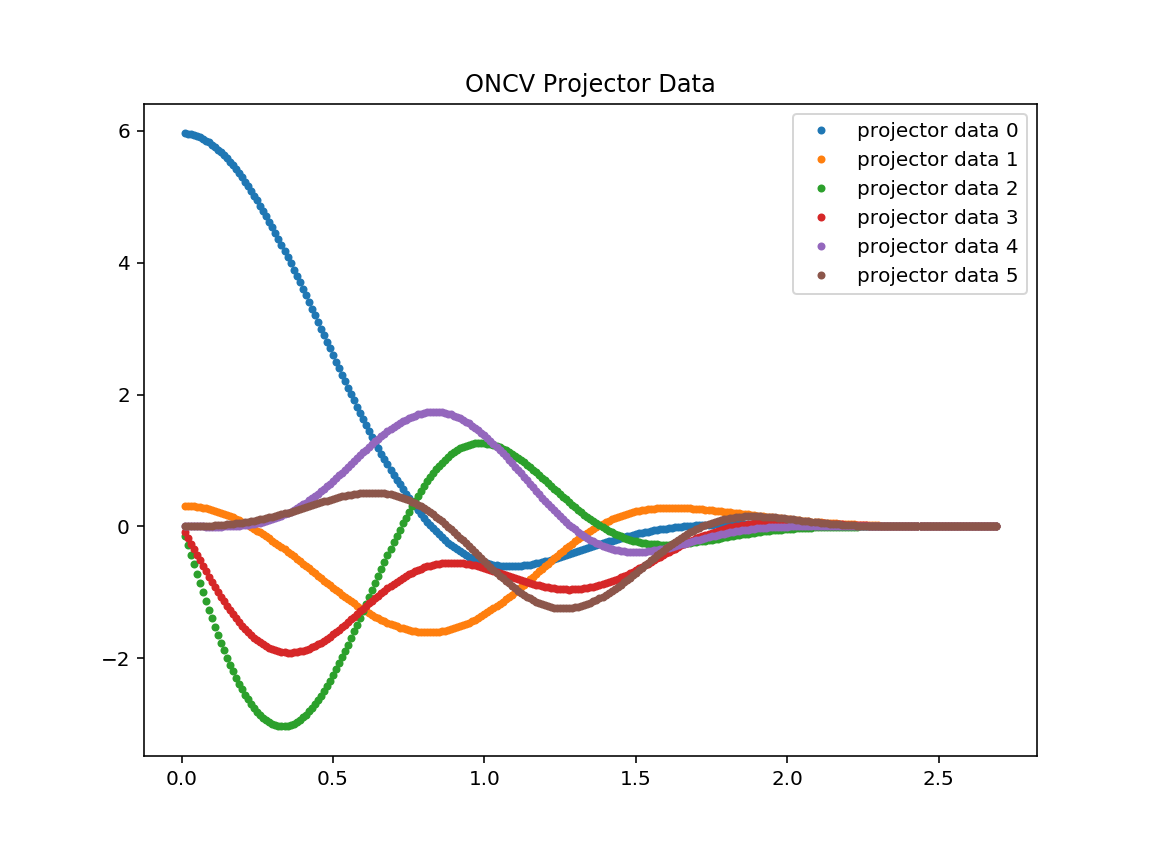

/Users/nathanvaughn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


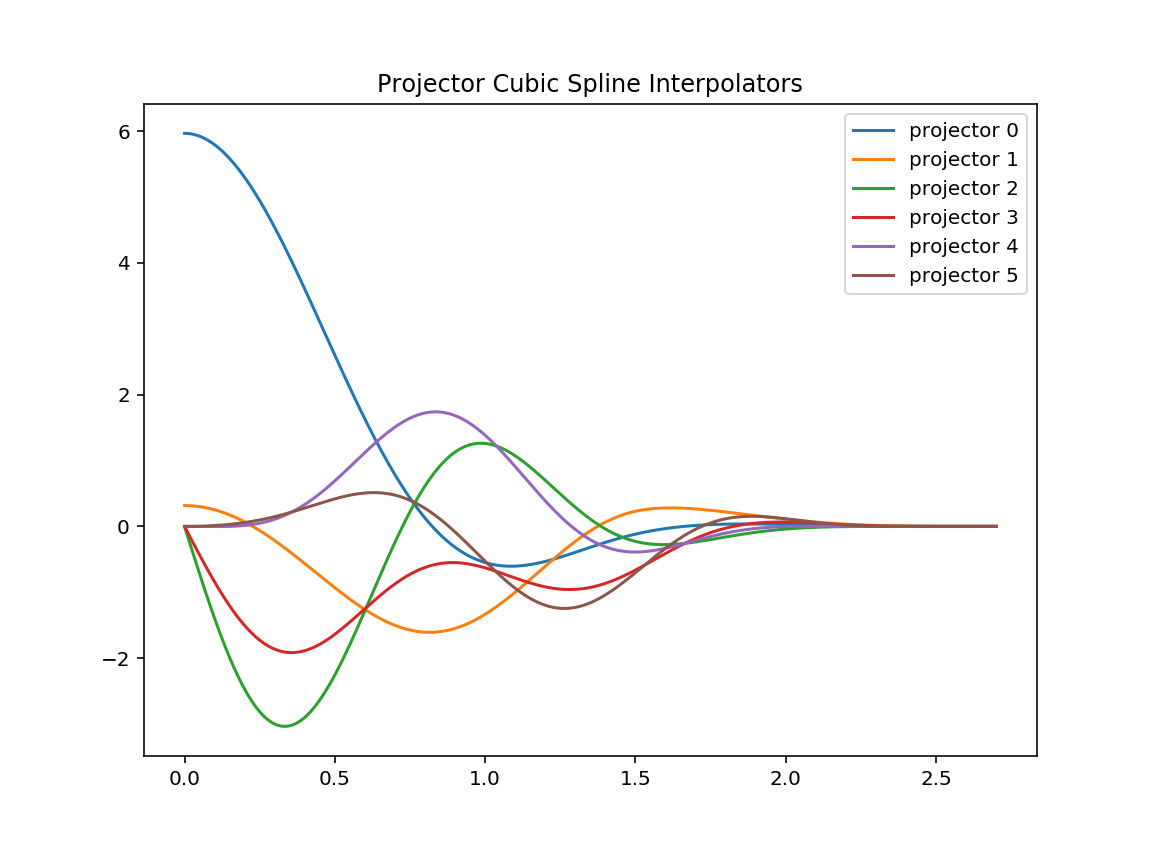

/Users/nathanvaughn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in true_divide
/Users/nathanvaughn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in true_divide


In [264]:
PSPs={}
Atom1 = Atom(0.0,0.0,0.0,47,3)
Atom1.setPseudopotentialObject(PSPs)
print(Atom1.PSP.psp['header'])
# Atom1.PSP.psp['D_ion']
# %matplotlib notebook
# Atom1.PSP.plotDensity()
# %matplotlib notebook
# Atom1.PSP.plotLocalPotential(ylims=[-1.3])
# %matplotlib notebook
# Atom1.PSP.plotProjectors()

# for i in range(Atom1.PSP.psp['header']['number_of_proj']):
#     print(Atom1.PSP.psp['beta_projectors'][i]['angular_momentum'])



In [11]:
PSPs = {}
for Z in [1, 3, 6]:
    PSPs[str(Z)] = ONCV_PSP(Z)
PSPs

{'1': <__main__.ONCV_PSP at 0x7ffaa0937550>,
 '3': <__main__.ONCV_PSP at 0x7ffaa0937588>,
 '6': <__main__.ONCV_PSP at 0x7ffaa0bd4c18>}

In [207]:
PSPs={}
Atom1 = Atom(0.0,0.0,0.0,6,3)
Atom1.setPseudopotentialObject(PSPs)
Atom2 = Atom(1.0,1.0,1.0,6,3)
Atom2.setPseudopotentialObject(PSPs)
Atom3 = Atom(1.0,1.0,1.0,8,3)
Atom3.setPseudopotentialObject(PSPs)

print(Atom1.PSP)
print(Atom2.PSP['header'])
print(PSPs)

Setting PSP for atomic number  6
Setting PSP for atomic number  6
Setting PSP for atomic number  8


TypeError: 'ONCV_PSP' object is not subscriptable

Setting PSP for atomic number  6


<IPython.core.display.Javascript object>


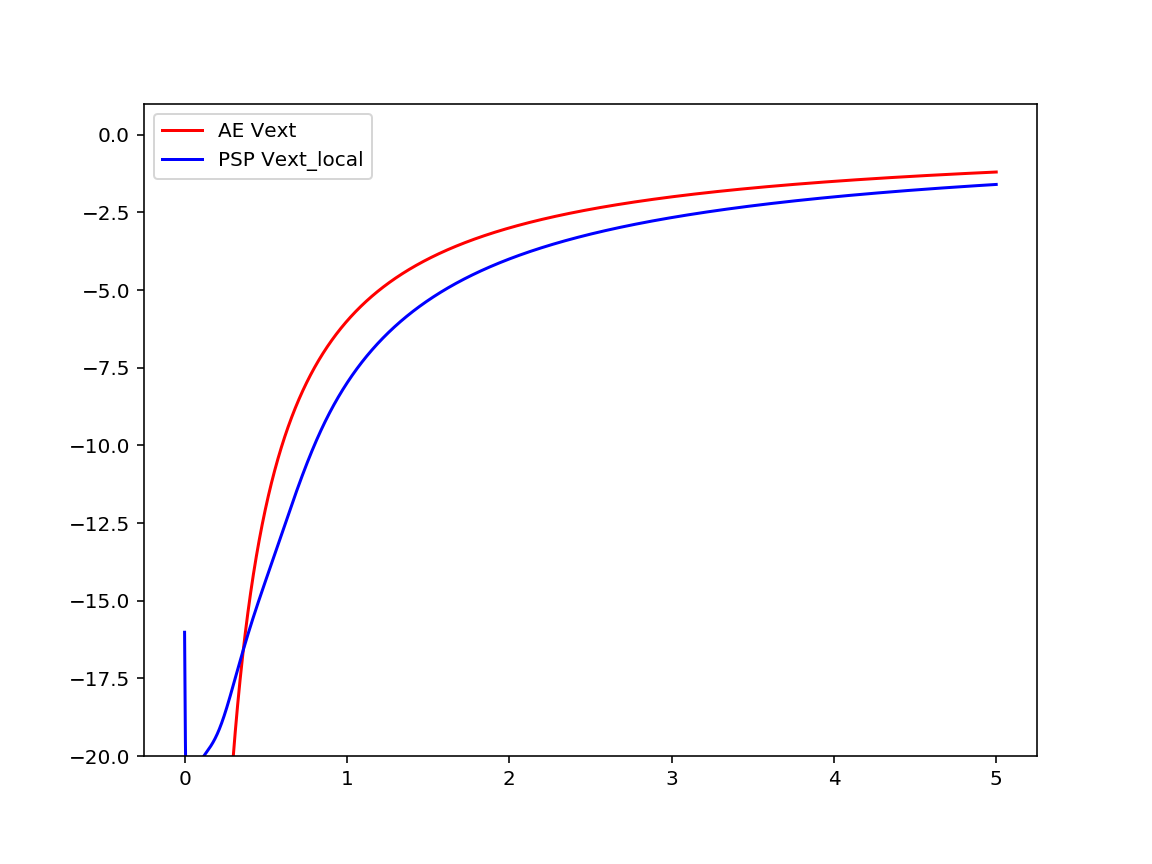

In [206]:
Atom1=None
PSPs={}
Atom1 = Atom(0.0,0.0,0.0,6,3)
Atom1.setPseudopotentialObject(PSPs)

r = np.linspace(1e-5,5,5000)
x = r
y = np.zeros_like(r)
z = np.zeros_like(r)


V_ext_ae  = Atom1.V_all_electron(x,y,z)
V_ext_psp = Atom1.V_local_pseudopotential(x,y,z)

density_ae  = Atom1.interpolators['density'](r)
density_psp = Atom1.PSP.evaluateDensityInterpolator(r)

# plt.figure(figsize=(8, 6))
# plt.plot(r,density_ae,'r',label="AE Density")
# plt.plot(r,density_psp,'b',label="PSP Density")
# plt.legend()

%matplotlib notebook
plt.figure(figsize=(8, 6))
plt.plot(r,V_ext_ae,'r',label="AE Vext")
plt.plot(r,V_ext_psp,'b',label="PSP Vext_local")
plt.ylim([-20,1])
plt.legend()


# plt.figure(figsize=(8, 6))
# plt.plot(r,np.sqrt(density_ae)*V_ext_ae,'r',label="AE Vext*sqrt(density)")
# plt.plot(r,np.sqrt(density_psp)*V_ext_psp,'b',label="PSP Vext_local*sqrt(density)")
# plt.ylim([-20,1])
# plt.legend()


# plt.show()

In [254]:
## Reshaping for interpolator
M = np.random.rand(4,4,4)
for i in range(4):
    for j in range(4):
        for k in range(4):
            M[i][j][k] = j+4*k+16*i
# print(M)

# print(2*M-np.reshape(2*M.flatten(),(4,4,4)))
np.reshape(Atom1.PSP.evaluateDensityInterpolator(M.flatten()),(4,4,4))

array([[[2.32064192e+00, 1.19617647e-03, 3.76602238e-06, 1.79780924e-08],
        [9.19613927e-02, 2.79189340e-04, 9.57940774e-07, 4.93151324e-09],
        [1.61985958e-02, 6.46014972e-05, 2.49795428e-07, 1.36889975e-09],
        [4.89662609e-03, 1.52793888e-05, 6.64599366e-08, 3.83889298e-10]],

       [[1.08619892e-10, 7.46676650e-13, 5.56946281e-15, 4.39504129e-17],
        [3.09750700e-11, 2.18029259e-13, 1.65240531e-15, 1.31899708e-17],
        [8.89459004e-12, 6.39541623e-14, 4.91825125e-16, 3.96787633e-18],
        [2.56994928e-12, 1.88373285e-14, 1.46821848e-16, 1.19629437e-18]],

       [[3.61428417e-19, 3.06732985e-21, 2.66863225e-23, 2.36889925e-25],
        [1.09409537e-19, 9.34808909e-22, 8.17714705e-24, 7.29101051e-26],
        [3.31807374e-20, 2.85311913e-22, 2.50860191e-24, 2.24624900e-26],
        [1.00801870e-20, 8.72004431e-23, 7.70467325e-25, 6.92689574e-27]],

       [[2.13802461e-27, 1.95673367e-29, 1.81219773e-31, 1.69559593e-33],
        [6.60486312e-28, 6.06383

In [246]:
4%2

0

In [247]:
5%2

1